<a href="https://colab.research.google.com/github/rajadevineni/Income_classification/blob/main/income_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and dataset

In [1]:
!pip install feature_engine

     |████████████████████████████████| 9.5MB 6.0MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path

pd.pandas.set_option('display.max_columns', None)
%matplotlib inline

## Grid Search import

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Load, Inspecting and cleaning the data

In [76]:
# load dataset
# Dataset is extracted from https://sci2s.ugr.es/keel/dataset.php?cod=192

path = "https://raw.githubusercontent.com/rajadevineni/Income_classification/main/adult.csv"
data = pd.read_csv(path)
print('Number of records in the Dataset: ', len(data))
print('Number of features in the Dataset: ', data.shape[1])
data.head(5)

Number of records in the Dataset:  48842
Number of features in the Dataset:  15


,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


## Types of variables



In [78]:
# List for categorical variables
categorical = [var for var in data.columns if data[var].dtype=='O']

# List for numerical variables
numerical = [var for var in data.columns if data[var].dtype!='O']

# list of variables that contain year information
year_vars = [var for var in numerical if 'Yr' in var or 'Year' in var]

#To identify discrete variables- numerical variables with less than 20 unique values 
# List for discrete variables
discrete = [var for var in numerical if len(data[var].unique()) < 20 and var not in year_vars]

# List for continuous variables
continuous = [var for var in numerical if var not in discrete and var not in [
    'id', 'target'] and var not in year_vars]

print(f'There are {len(categorical)} categorical variables:',categorical)
print(f'There are {len(numerical)} numerical variables:',numerical)
print(f'There are {len(year_vars)} temporal variables:',year_vars)
print(f'There are {len(discrete)} discrete variables:', discrete)
print(f'There are {len(continuous)} continuous variables:', continuous)

There are 9 categorical variables: ['Workclass', 'Education', 'Marital-status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native-country', 'Class']
There are 6 numerical variables: ['Age', 'Fnlwgt', 'Education-num', 'Capital-gain', 'Capital-loss', 'Hours-per-week']
There are 0 temporal variables: []
There are 1 discrete variables: ['Education-num']
There are 5 continuous variables: ['Age', 'Fnlwgt', 'Capital-gain', 'Capital-loss', 'Hours-per-week']


## Inspecting Data

### Checking for null values in the dataset

* There are null values in Workclass, Occupation and Native-country column

In [81]:
print(data.isna().sum())
#print(data.isnull().mean())

Age                  0
Workclass         2799
Fnlwgt               0
Education            0
Education-num        0
Marital-status       0
Occupation        2809
Relationship         0
Race                 0
Sex                  0
Capital-gain         0
Capital-loss         0
Hours-per-week       0
Native-country     857
Class                0
dtype: int64


### Inspecting the variable values

* Education-num column is the ordinal representation of Education column, therefore we can drop Education-num column

In [86]:
for var in data.columns:
    print(var, data[var].unique()[0:20], '\n')

Age [25 38 28 44 18 34 29 63 24 55 65 36 26 58 48 43 20 37 40 72] 

Workclass ['Private' 'Local-gov' nan 'Self-emp-not-inc' 'Federal-gov' 'State-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked'] 

Fnlwgt [226802  89814 336951 160323 103497 198693 227026 104626 369667 104996
 184454 212465  82091 299831 279724 346189 444554 128354  60548  85019] 

Education ['11th' 'HS-grad' 'Assoc-acdm' 'Some-college' '10th' 'Prof-school'
 '7th-8th' 'Bachelors' 'Masters' 'Doctorate' '5th-6th' 'Assoc-voc' '9th'
 '12th' '1st-4th' 'Preschool'] 

Education-num [ 7  9 12 10  6 15  4 13 14 16  3 11  5  8  2  1] 

Marital-status ['Never-married' 'Married-civ-spouse' 'Widowed' 'Divorced' 'Separated'
 'Married-spouse-absent' 'Married-AF-spouse'] 

Occupation ['Machine-op-inspct' 'Farming-fishing' 'Protective-serv' nan
 'Other-service' 'Prof-specialty' 'Craft-repair' 'Adm-clerical'
 'Exec-managerial' 'Tech-support' 'Sales' 'Priv-house-serv'
 'Transport-moving' 'Handlers-cleaners' 'Armed-Forces'] 

Relationship 

# Correlations and Choosing variables

In [80]:
data.describe()

,Age,Fnlwgt,Education-num,Capital-gain,Capital-loss,Hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


### Creating correlation matrix

In [41]:
corr_matrix = data.corr(method='pearson', min_periods=1)
corr_matrix.head(10)

,Age,Fnlwgt,Education-num,Capital-gain,Capital-loss,Hours-per-week
Age,1.000000,-0.076628,0.030940,0.077229,0.056944,0.071558
Fnlwgt,-0.076628,1.000000,-0.038761,-0.003706,-0.004366,-0.013519
Education-num,0.030940,-0.038761,1.000000,0.125146,0.080972,0.143689
Capital-gain,0.077229,-0.003706,0.125146,1.000000,-0.031441,0.082157
Capital-loss,0.056944,-0.004366,0.080972,-0.031441,1.000000,0.054467
Hours-per-week,0.071558,-0.013519,0.143689,0.082157,0.054467,1.000000


In [ ]:
def highest_corr(df):
  high_corr_pairs = set()
  cols = df.columns
  ids = df.index
  for i in range(0, df.shape[1]):
    for j in range(0,i+1):
      if df.iloc[i,j]>=0.5:        
        if cols[i]!=ids[j]:
          high_corr_pairs.add((cols[i], ids[j]))
          print(cols[i],cols[j])
  return high_corr_pairs
print("Highly correlated pairs:")
print("Total Highly correlated pairs",len(highest_corr(corr_matrix)))

## Distribution of Variables

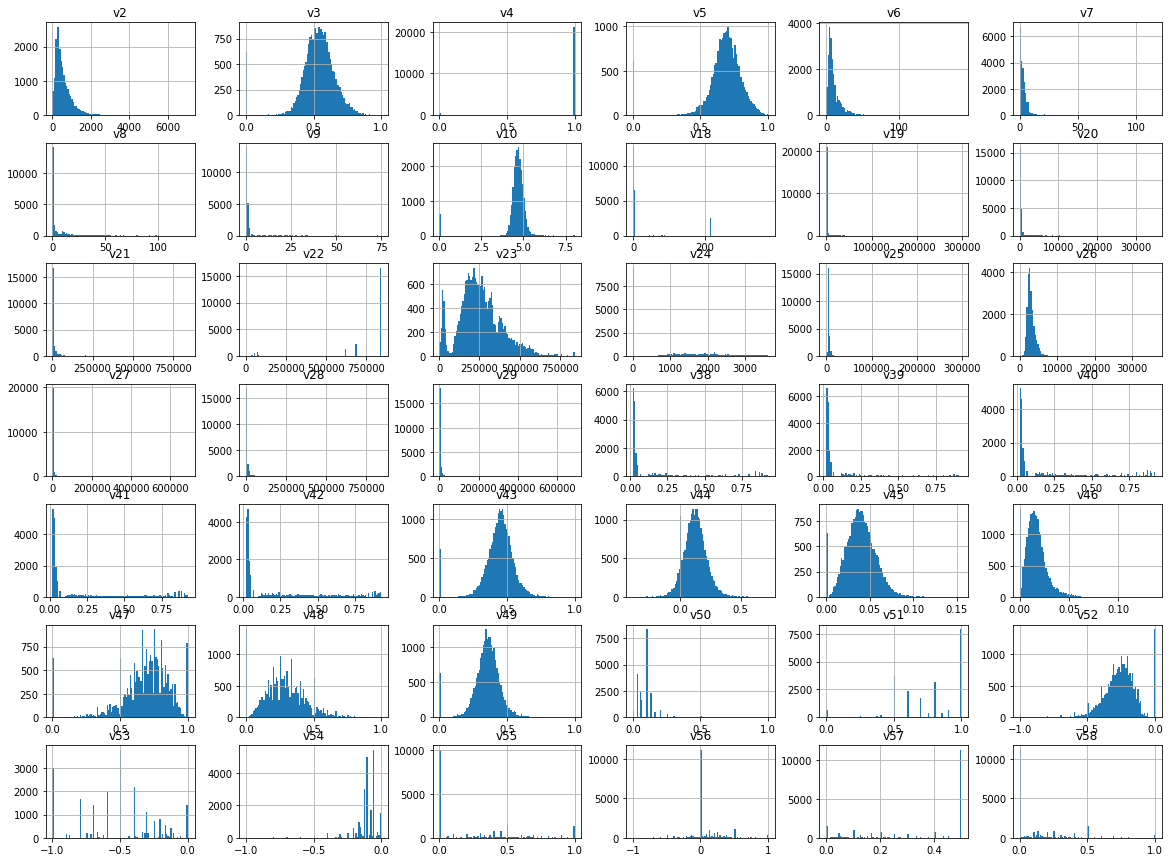

In [ ]:
data[continuous].hist(bins=100, figsize=(20,15))
plt.show()

## **Distribution of Target**

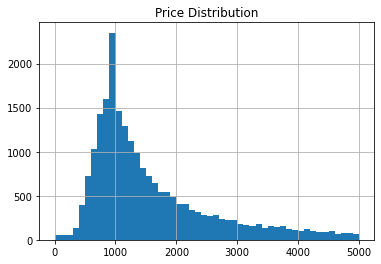

In [ ]:
data['target'].hist(bins=50)
plt.title("Price Distribution")
plt.ticklabel_format(useOffset=False, style='plain') # removing the scientific scales on the axes
plt.show()

### **Visualizing dependancy of Target on Continous Features**

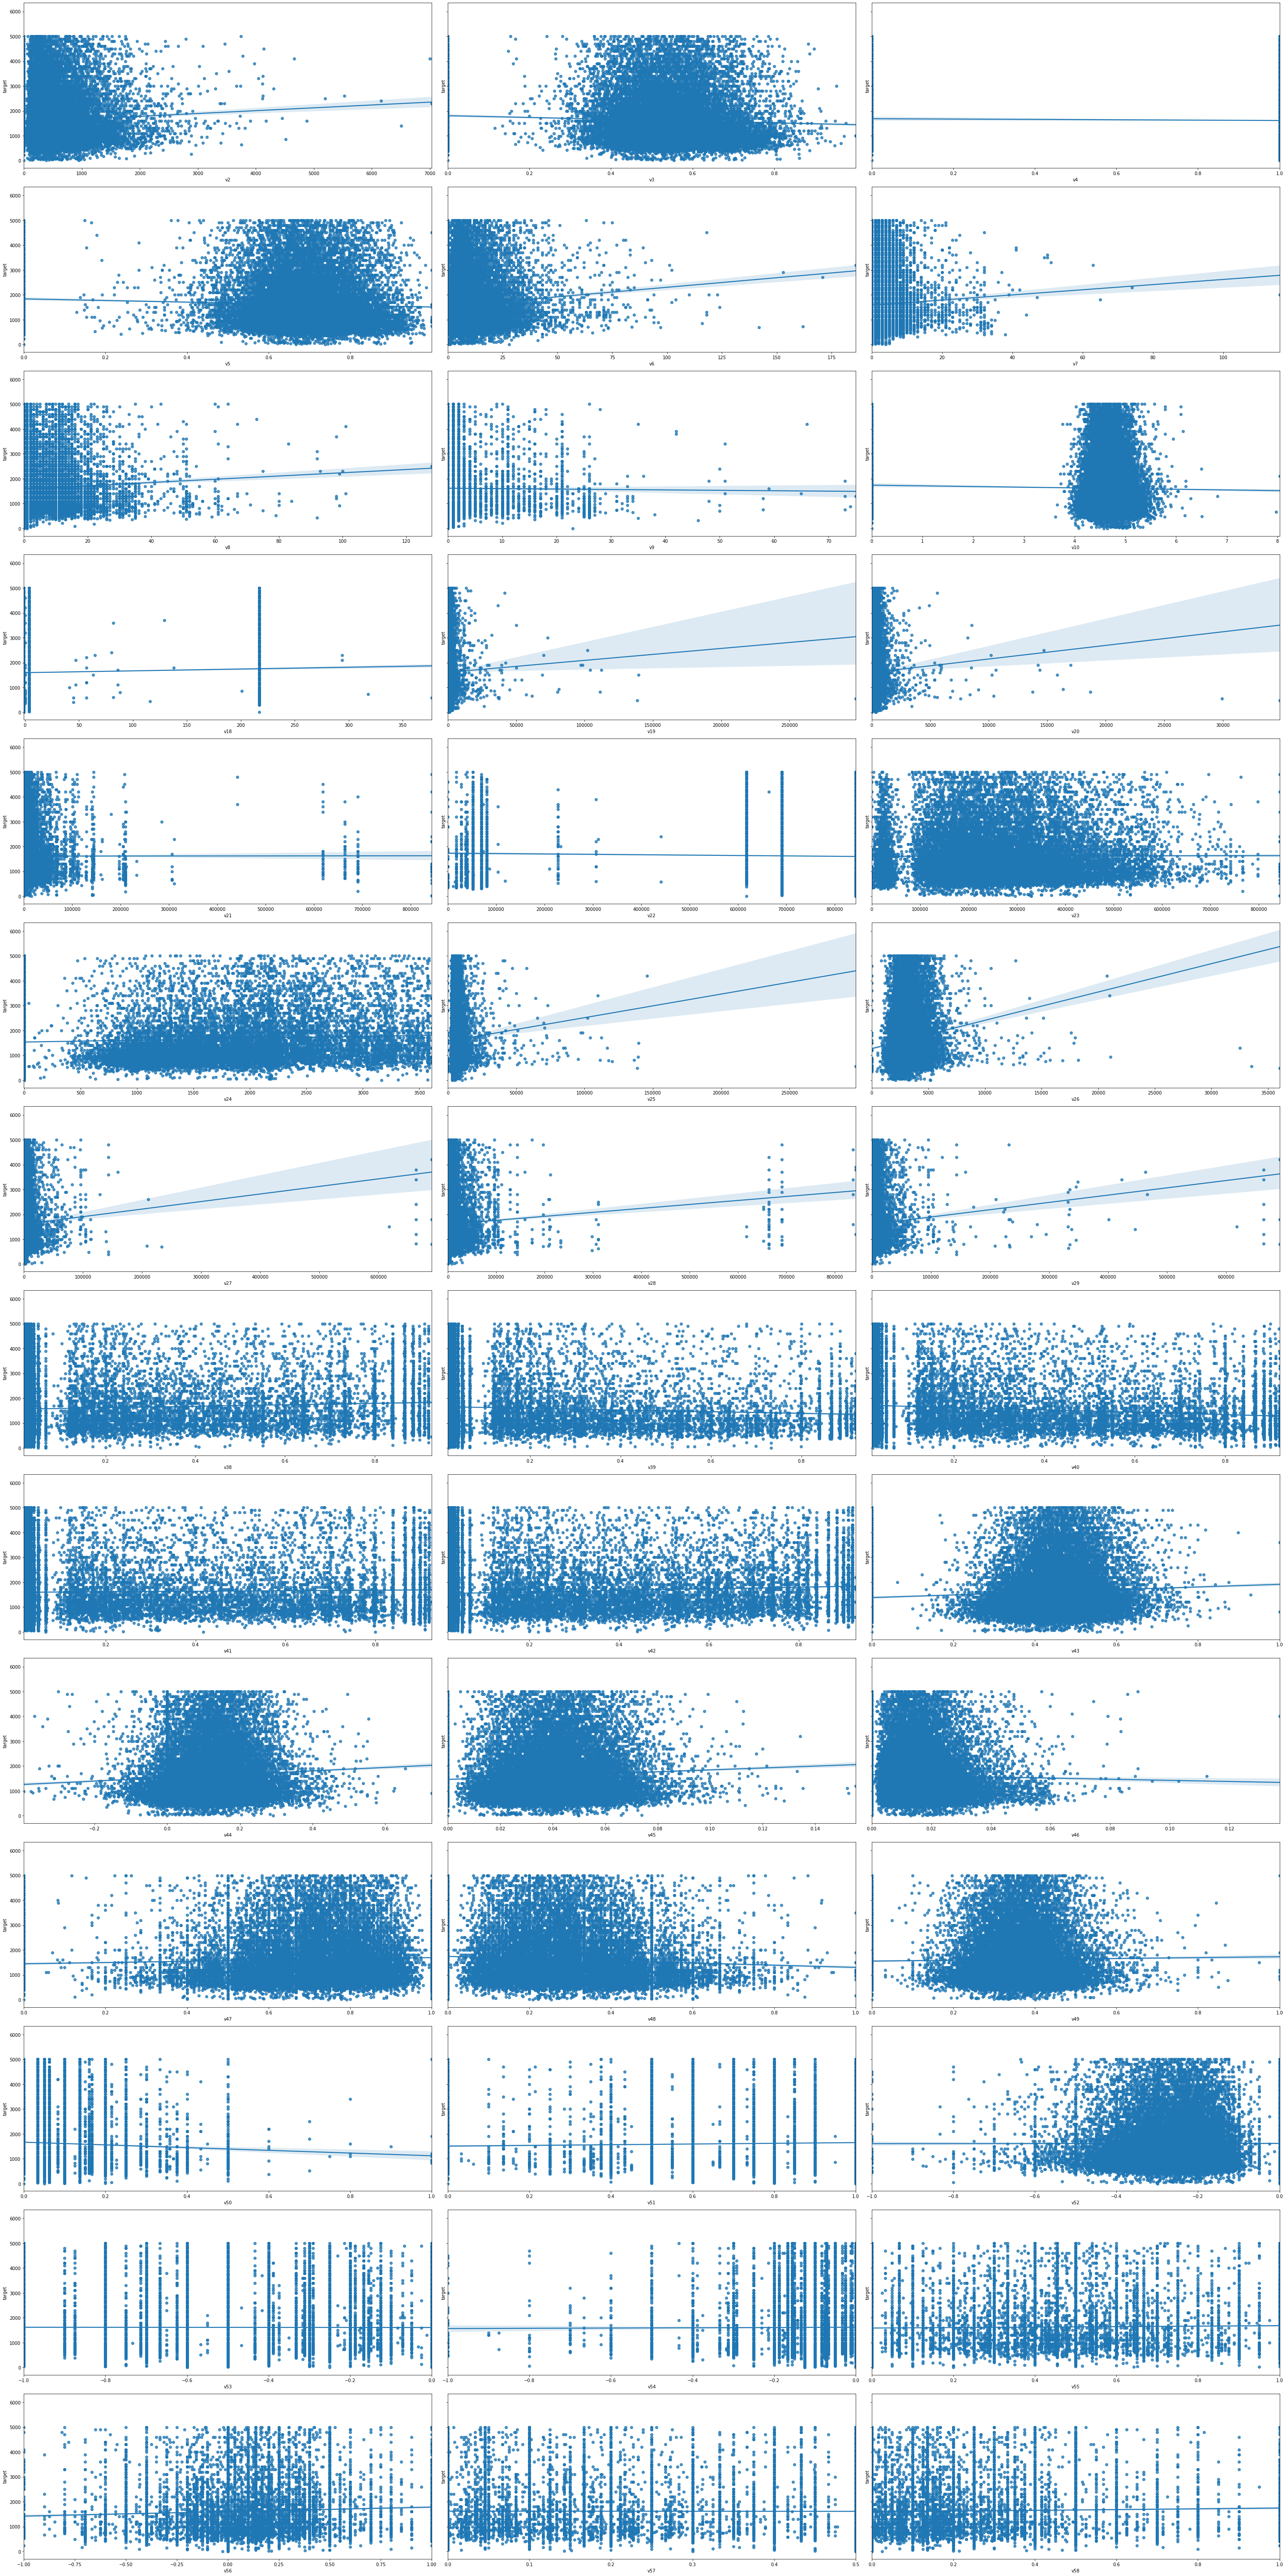

In [ ]:
rows = len(continuous)//3
fig, axs = plt.subplots(rows, 3, sharey=True, tight_layout=True, figsize=(40,80))
axs = axs.flatten()
for i, var in enumerate(continuous):
  sns.regplot(x = var, y = "target", data = data, ax=axs[i])



## Data Capping


I noticed that there are some outlier that could potentially affect the regression, removing the outliers could help make better predictions

* Capping target to <=3500
* Capping v29 <=150000
* Capping v27 <=150000
* Capping v28 <=300000
* Capping v46 <=0.08

In [ ]:
data_capp = data[
     (data["target"] <= 3500) &
     (data['v29']<=150000) &
     (data['v27']<=150000) &
     (data['v28']<=300000) &
     (data['v46']<=0.08) 
    ]
print(data_capp.shape)

(20147, 60)
